# Cell segmentation
We can use the high resolution tissue images to segment nuclei. This information can be used as additional features. Wr provide two segmentation models `SegmentationModelBlob` and `SegmentationModelWatershed`. In addition, you can use your own pre-tranined `tensorflow.keras` model to do the segmentation.

In this notebook, we show how to use the segmentation models and what kind of parameters you can use.

In [213]:
img.data.y.shape[0]

24240

In [215]:
res = img.data.isel(y=slice(20000, 24240), x=slice(1000))

In [239]:
def scale(arr, scale):
            # rescale only in x and y dim
            scales = np.ones(len(arr.dims))
            scales[np.in1d(arr.dims, ['y', 'x'])] = scale
            
from skimage.transform import rescale

In [245]:
import skimage.draw
skimage.draw.disk((10,10),2)

(array([ 9,  9,  9, 10, 10, 10, 11, 11, 11]),
 array([ 9, 10, 11,  9, 10, 11,  9, 10, 11]))

In [253]:
import xarray as xr

In [254]:
# helper function for scaling one xarray
def scale_xarray(arr, scale):
    dtype = arr.dtype
    dims = arr.dims

    # rescale only in x and y dim
    scales = np.ones(len(dims))
    scales[np.in1d(dims, ['y', 'x'])] = scale

    arr = rescale(arr.values, scales, preserve_range=True, order=1)
    arr = arr.astype(dtype)
    # recreate DataArray
    arr = xr.DataArray(arr, dims=dims)

    return arr

In [255]:
res.map(scale_xarray, scale=0.5)

<xarray.Dataset>
Dimensions:              (channels: 4, mask: 1, x: 500, y: 2120)
Dimensions without coordinates: channels, mask, x, y
Data variables:
    image                (channels, y, x) uint16 1564 1586 1595 ... 8402 8280
    segmented_watershed  (mask, y, x) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0

In [248]:
res.where((res.x-0)**2 + (res.y-0)**2 < 10**2)

<xarray.Dataset>
Dimensions:              (channels: 4, mask: 1, x: 1000, y: 4240)
Coordinates:
  * channels             (channels) int64 1 1 1 1
Dimensions without coordinates: mask, x, y
Data variables:
    image                (channels, y, x) float64 1.532e+03 1.548e+03 ... nan
    segmented_watershed  (mask, y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan

In [240]:
res['image'].dtype


dtype('uint16')

In [233]:
dims = res['image'].dims

In [238]:
l = [1,2,3]
l[[True, False, True]] = 2
print(l)

TypeError: list indices must be integers or slices, not list

In [235]:
np.where(np.in1d(dims, ['y', 'x']))[0]

array([1, 2])

In [220]:
res['image'].values

array([[[1532, 1548, 1568, ..., 1580, 1576, 1564],
        [1564, 1604, 1596, ..., 1592, 1568, 1552],
        [1576, 1588, 1572, ..., 1568, 1568, 1564],
        ...,
        [1556, 1592, 1568, ..., 1580, 1588, 1592],
        [1584, 1576, 1572, ..., 1576, 1612, 1612],
        [1584, 1564, 1568, ..., 1548, 1580, 1612]],

       [[1892, 1940, 1920, ..., 2016, 1996, 2004],
        [1996, 2064, 2016, ..., 2088, 2024, 1980],
        [2036, 2052, 2060, ..., 2048, 2072, 2044],
        ...,
        [1956, 1988, 1952, ..., 1976, 2052, 2108],
        [1960, 2000, 1996, ..., 1988, 2112, 2132],
        [1968, 2004, 2000, ..., 1972, 2084, 2120]],

       [[2312, 2348, 2500, ..., 2432, 2504, 2480],
        [2380, 2340, 2360, ..., 2352, 2360, 2324],
        [2408, 2316, 2316, ..., 2484, 2460, 2364],
        ...,
        [2348, 2428, 2536, ..., 2404, 2520, 2520],
        [2372, 2460, 2564, ..., 2548, 2672, 2628],
        [2432, 2460, 2532, ..., 2672, 2696, 2560]],

       [[6952, 7240, 7380, ..., 7840,

In [227]:
res.pad(x=(0,0), y=(0,0), mode="constant", constant_values=0)['image'].values

array([[[1532, 1548, 1568, ..., 1580, 1576, 1564],
        [1564, 1604, 1596, ..., 1592, 1568, 1552],
        [1576, 1588, 1572, ..., 1568, 1568, 1564],
        ...,
        [1556, 1592, 1568, ..., 1580, 1588, 1592],
        [1584, 1576, 1572, ..., 1576, 1612, 1612],
        [1584, 1564, 1568, ..., 1548, 1580, 1612]],

       [[1892, 1940, 1920, ..., 2016, 1996, 2004],
        [1996, 2064, 2016, ..., 2088, 2024, 1980],
        [2036, 2052, 2060, ..., 2048, 2072, 2044],
        ...,
        [1956, 1988, 1952, ..., 1976, 2052, 2108],
        [1960, 2000, 1996, ..., 1988, 2112, 2132],
        [1968, 2004, 2000, ..., 1972, 2084, 2120]],

       [[2312, 2348, 2500, ..., 2432, 2504, 2480],
        [2380, 2340, 2360, ..., 2352, 2360, 2324],
        [2408, 2316, 2316, ..., 2484, 2460, 2364],
        ...,
        [2348, 2428, 2536, ..., 2404, 2520, 2520],
        [2372, 2460, 2564, ..., 2548, 2672, 2628],
        [2432, 2460, 2532, ..., 2672, 2696, 2560]],

       [[6952, 7240, 7380, ..., 7840,

In [207]:
img.data.y.shape

(24240,)

In [208]:
res['image'].shape

(4, 1000, 1000)

In [1]:
# import modules
import squidpy as sq
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set path to dataset
BASE_PATH = "../../data"

## Load data
Here, we use a human brain fluorescence dataset

In [3]:
# set path to dataset
BASE_PATH = "../../data"
dataset_folder = os.path.join(BASE_PATH, "2020_10XFluoVisium_HumanBrain1_giovanni.palla")
# load data
adata, img = sq.read_visium_data(dataset_folder)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


ImageContainer object with 1 layers
    image: channels (4), y (24240), x (24240)



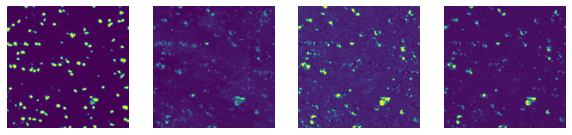

In [4]:
print(img)

# plot small example crop from img
crop = img.crop_corner(10000, 10000, xs=1000, ys=1000)

fig, axes = plt.subplots(1,4, figsize=(10,20))
for i,ax in enumerate(axes):
    ax.imshow(crop[i])
    ax.axis('off')

stain 0 is DAPI, allows to distinguish individual nuclei

(array([5.0444430e+08, 2.8228494e+07, 1.4052832e+07, 7.6950460e+06,
        5.4322910e+06, 4.1703310e+06, 3.3808390e+06, 2.8534460e+06,
        2.5307100e+06, 1.4789311e+07]),
 array([    0. ,  6553.2, 13106.4, 19659.6, 26212.8, 32766. , 39319.2,
        45872.4, 52425.6, 58978.8, 65532. ]),
 <BarContainer object of 10 artists>)

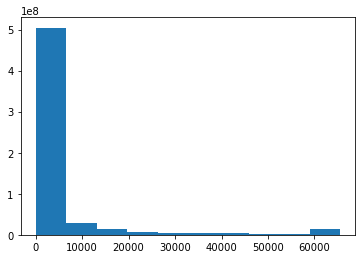

In [5]:
# plot histogram for 0th stain to identify an adequate threshold
plt.hist(np.asarray(img.data["image"][0]).flatten())

there is a small peak at 60000, lets choose 50000 as a threshold for the watershed segmentation

## Segmentation method
we use `sq.im.segment` to segment an entire image. For large images, you can choose to tile the image in smaller crops and process them individually.
### Watershed

In [64]:
import importlib
import squidpy
importlib.reload(squidpy.im.crop)

<module 'squidpy.im.crop' from '/Users/hannah.spitzer/projects/spatial_scanpy/squidpy/squidpy/im/crop.py'>

In [168]:
sq.im.segment_img(img=img, img_id="image", model_group="watershed", channel_idx=0,
              model_kwargs={'thresh': 50000}, xs=1000, ys=1000)

0 0 0 int32
0 0 0 int32
0 0 0 int32
0 0 0 int32
0 0 0 int32
0 58 58 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 0 0 int32
58 1 1 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 0 0 int32
59 34 34 int32
93 9 9 int32
102 73 73 int32
175 62 62 int32
237 45 45 int32
282 13 13 int32
295 23 23 int32
318 47 47 int32
365 54 54 int32
419 67 67 int32
486 15 15 int32
501 7 7 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 0 0 int32
508 76 76 int32
584 132 13

ImageContainer object with 2 layers
    image: channels (4), y (24240), x (24240)
    segmented_watershed: mask (1), y (24240), x (24240)



Text(0.5, 1.0, 'segmentation')

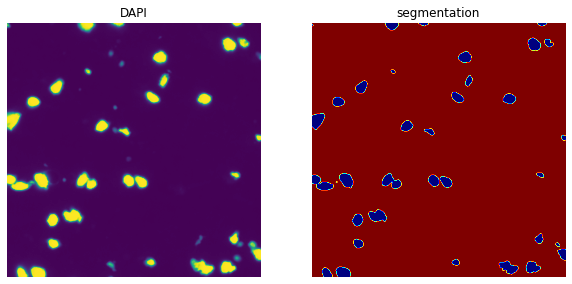

In [174]:
print(img)

# plot example result
crop = img.crop_corner(10000, 10000, xs=500, ys=500, img_id='image')
crop_seg = img.crop_corner(10000, 10000, xs=500, ys=500, img_id='segmented_watershed')

fig, axes = plt.subplots(1,2, figsize=(10,20))
axes[0].imshow(crop[0])
axes[0].axis('off')
axes[0].set_title('DAPI')

axes[1].imshow(crop_seg[0], cmap='jet')
axes[1].axis('off')
axes[1].set_title('segmentation')

(array([ 10768.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 239232.]),
 array([    0. ,  6634.7, 13269.4, 19904.1, 26538.8, 33173.5, 39808.2,
        46442.9, 53077.6, 59712.3, 66347. ]),
 <BarContainer object of 10 artists>)

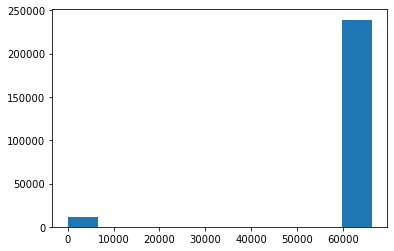

In [170]:
plt.hist(crop_seg.values.flatten())

## Segmentation format
Above, we showed how the entire image can be segmented through integration across crop-wise segementations. Additionally, one can also segment a specific crop:

In [146]:
importlib.reload(squidpy.im)
importlib.reload(squidpy)
importlib.reload(squidpy.im.segment)
importlib.reload(squidpy.im.crop)

<module 'squidpy.im.crop' from '/Users/hannah.spitzer/projects/spatial_scanpy/squidpy/squidpy/im/crop.py'>

In [182]:
crop = sq.im.ImageContainer(
    img=img.crop_corner(x=5500, y=5500, xs=500, ys=500),
    img_id="crop",
)

print(crop)

ImageContainer object with 1 layers
    crop: channels (4), y (500), x (500)



In [183]:
sq.im.segment_img(img=crop, img_id="crop", model_group="watershed", channel_idx=0,
    model_kwargs={
        "thresh": 50000, 
        "geq": False
    }, xs=100, ys=100)

0 1 1 int32
1 0 0 int32
1 0 0 int32
1 3 3 int32
4 1 1 int32
5 2 2 int32
7 7 7 int32
14 4 4 int32
18 0 0 int32
18 9 9 int32
27 2 2 int32
29 0 0 int32
29 2 2 int32
31 5 5 int32
36 8 8 int32
44 4 4 int32
48 0 0 int32
48 0 0 int32
48 0 0 int32
48 5 5 int32
53 3 3 int32
56 0 0 int32
56 5 5 int32
61 2 2 int32
63 2 2 int32


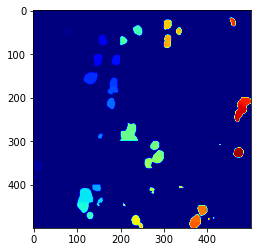

In [184]:
plt.imshow(crop.data["segmented_watershed"][0], cmap='jet')

In [189]:
crop

ImageContainer object with 2 layers
    crop: channels (4), y (500), x (500)
    segmented_watershed: mask (1), y (500), x (500)

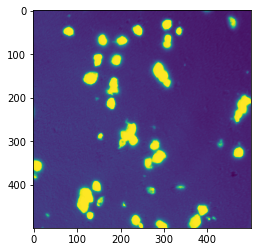

In [190]:
plt.imshow(crop.data['crop'][0])

In [199]:
import skimage.measure
def get_segmentation_features(img, features_name='segmentation', props=['label', 'area', 'eccentricity']):
    img.data['segmented_watershed']
    
    res = skimage.measure.regionprops_table(img.data['segmented_watershed'][0].values, #img.data['crop'][1].values,
                                        properties=['label', 'area', 'eccentricity', 'solidity', 'mean_intensity'])
    num_segments = len(res['label'])
    mean_area = np.mean(res['area'])
    mean_eccentricity = np.mean(res['eccentricity'])
    #mean_intensity = np.mean(res['mean_intensity'])
    print(res)
    #mean_solidity = np.mean('solidity')
    # todo could add mean intensity of specific channel
    return [num_segments, mean_area, mean_eccentricity]# mean_solidity]

get_segmentation_features(crop)
    

KeyError: 'mean_intensity'